In [1]:
import cvxpy as cp
from matplotlib import pyplot as plt
import numpy as np
import sea2025

Worksheet 4: Non-marginal costs and dynamic constraints
=======================================================

OPF provides dispatch instructions and marginal prices ($/MWh) for one period, but it does not explicitly account for
* Physical constraints on
  - ramping;
  - allowable up-time / down-time;
* Economic realities:
  - Fixed operating costs ($/h)
  - Costs of start-up and shut-down ($)

# Objective

Familiarity with the Unit Commitment problem:
* Extra binary decision variables and associated costs & constraints
* Significant computational complexity (relative to OPF)


In [2]:
data = sea2025.data.read("data/ne8bus")

# Take references for brevity
buses = data.buses
generators = data.generators
lines = data.lines
loads = data.loads
offers = data.offers
reference_bus = data.reference_bus
base_power = data.base_power

Optionally, make the problem smaller (to reduce solver time) for demonstation:

In [3]:
loads = loads.iloc[: loads.index.size // 1, :]
loads.head()

,hour,CT,ME,NEMA,NH,RI,SEMA,VT,WCMA
0,1,980,2136,1236,1565,680,2735,518,939
1,2,954,2032,1171,1495,644,2584,498,898
2,3,942,1990,1145,1466,628,2519,490,875
3,4,943,1976,1136,1454,621,2504,488,876
4,5,968,2010,1156,1472,631,2544,501,908


Incidence matrices, as before, to simplify the formulation:

In [4]:
generator_bus = sea2025.incidence.generator_bus(buses=buses, generators=generators)
generator_offer = sea2025.incidence.generator_offer(generators=generators, offers=offers)
line_bus = sea2025.incidence.line_bus(buses=buses, lines=lines)
offer_bus = sea2025.incidence.offer_bus(buses=buses, offers=offers, generators=generators)

reference_bus_index = sea2025.incidence.reference_bus(buses, reference_bus)

More references, for brevity:

In [5]:
offer_quantity = offers["quantity"].values
offer_price = offers["price"].values
p_min = generators["capacity"].values * 0.2
p_max = generators["capacity"].values
reactance_pu = lines["reactance"].values
line_capacity = lines["capacity"].values
ramp = generators["ramp_rate"].values
startup_cost = generators["startup_cost"].values
shutdown_cost = np.zeros(startup_cost.size)  # unavailable!
noload_cost = generators["noload_cost"].values
bus_ids = buses["id"].tolist()

Uncomment for minimum up/down-time constraints:

In [6]:
# min_uptime = generators["min_uptime"].values
# min_downtime = generators["min_downtime"].values

Continuous decision variables: Named as before, but now for every planning period:

In [7]:
p = cp.Variable((len(offers), len(loads)), name="p")
f = cp.Variable((len(lines), len(loads)), name="f")
θ = cp.Variable((len(buses), len(loads)), name="θ")

Binary decision variables:

In [8]:
x_on = cp.Variable((len(generators), len(loads)), name="x_on", boolean=True)
x_su = cp.Variable((len(generators), len(loads)), name="x_su", boolean=True)
x_sd = cp.Variable((len(generators), len(loads)), name="x_sd", boolean=True)

Assemble constraints at each time period:

In [9]:
constraints: list[cp.Expression] = []
for t in loads.index:
    bus_loads = loads.loc[t, bus_ids]
    bus_injections = offer_bus.T @ p[:, t] + line_bus.T @ f[:, t]
    line_flows = cp.multiply(line_bus @ θ[:, t], base_power / reactance_pu)
    p_total_now = generator_offer @ p[:, t]
    constraints.extend(
        [
            bus_injections == bus_loads,
            f[:, t] == line_flows,
            θ[reference_bus_index, t] == 0,
            # Injection bounds
            p[:, t] >= 0,
            p[:, t] <= offer_quantity,
            p_total_now >= cp.multiply(x_on[:, t], p_min),
            p_total_now <= cp.multiply(x_on[:, t], p_max),
            # Flow bounds
            f[:, t] >= -line_capacity,
            f[:, t] <= +line_capacity,
            # Transitions are mutually exclusive
            x_su[:, t] + x_sd[:, t] <= 1,
            # Sanity check
            cp.abs(θ[:, t]) <= np.pi,
        ]
    )
    if t > 0:
        p_total_prev = generator_offer @ p[:, t - 1]
        constraints.extend(
            [
                # Ramping constraints
                p_total_now - p_total_prev <= ramp,
                p_total_prev - p_total_now <= ramp,
                # Binary logic
                x_su[:, t] - x_sd[:, t] == x_on[:, t] - x_on[:, t - 1],
            ]
        )

    # Constraints for minimum up/down-time: Implementation #1 - very expensive
    # for g in generators.index:
    #     constraints.extend(
    #         x_on[g, t + τ] >= x_su[g, t]
    #         for τ in range(min_uptime[g])
    #         if t + τ < series.hour.size
    #     )
    #     constraints.extend(
    #         x_on[g, t + τ] <= 1 - x_sd[g, t]
    #         for τ in range(min_downtime[g])
    #         if t + τ < series.hour.size
    #     )

# # Constraints for minimum up/down-time: Implementation #2 - expensive
# for g in generators.index:
#     constraints.extend(
#         cp.sum(x_on[g, t : t + min_uptime[g]]) >= min_uptime[g] * x_su[g, t]
#         for t in range(series.hour.size - min_uptime[g])
#     )
#     constraints.extend(
#         cp.sum(x_on[g, t : t + min_downtime[g]]) <= min_downtime[g] * (1 - x_sd[g, t])
#         for t in range(series.hour.size - min_downtime[g])
#     )

In [10]:
# Solution time increasees with problem size
print(f"# Constraints: {len(constraints)}")

# Constraints: 1341


In [11]:
objective = cp.Minimize(
    cp.sum(
        [
            offer_price @ p[:, t]
            + noload_cost @ x_on[:, t]
            + startup_cost @ x_su[:, t]
            + shutdown_cost @ x_sd[:, t]
            for t in loads.index
        ]
    )
)

In [ ]:
# Preprocess and solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.HIGHS, verbose=True)
print(f"       Status: {problem.status}")
print(f" Optimal cost: ${problem.value:,.2f}")

(CVXPY) Jul 22 12:37:39 PM: Your problem has 38400 variables, 77820 constraints, and 0 parameters.
(CVXPY) Jul 22 12:37:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 22 12:37:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 22 12:37:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 22 12:37:39 PM: Your problem is compiled with the CPP canonicalization backend.


                                     CVXPY                                     
                                     v1.7.1                                    


(CVXPY) Jul 22 12:37:39 PM: Compiling problem (target solver=HIGHS).
(CVXPY) Jul 22 12:37:39 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> HIGHS
(CVXPY) Jul 22 12:37:39 PM: Applying reduction Dcp2Cone


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 22 12:37:40 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 22 12:37:40 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 22 12:37:42 PM: Applying reduction HIGHS
(CVXPY) Jul 22 12:37:42 PM: Finished problem compilation (took 3.155e+00 seconds).
(CVXPY) Jul 22 12:37:42 PM: Invoking solver HIGHS  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 79356 rows; 39168 cols; 200784 nonzeros; 21888 integer variables (21888 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+04]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+04]
Presolving model
37032 rows, 38152 cols, 131576 nonzeros  0s
32912 rows, 36787 cols, 117001 nonzeros  0s

Solving MIP model with:
   32912 rows
   36787 cols (20881 binary, 0 integer, 0 implied int., 15906 continuous, 0 domain fixed)
   117001 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Sol

(CVXPY) Jul 22 12:54:42 PM: Problem status: optimal
(CVXPY) Jul 22 12:54:42 PM: Optimal value: 3.499e+07
(CVXPY) Jul 22 12:54:42 PM: Compilation took 3.155e+00 seconds
(CVXPY) Jul 22 12:54:42 PM: Solver (including time spent in interface) took 1.019e+03 seconds


 B    6187       0        30 100.00%   34992436.2184   34993302.338       0.00%     1080    415   9542    275627  1019.3s
      6208       0        30 100.00%   34992436.2184   34993302.338       0.00%     1081    415   9542    276285  1019.3s

Solving report
  Status            Optimal
  Primal bound      34993302.338
  Dual bound        34992436.2184
  Gap               0.00248% (tolerance: 0.01%)
  P-D integral      8.62309693691
  Solution status   feasible
                    34993302.338 (objective)
                    0 (bound viol.)
                    1.18591803044e-11 (int. viol.)
                    0 (row viol.)
  Timing            1019.29 (total)
                    0.00 (presolve)
                    0.00 (solve)
                    0.00 (postsolve)
  Max sub-MIP depth 9
  Nodes             6208
  Repair LPs        0 (0 feasible; 0 iterations)
  LP iterations     276285 (total)
                    119608 (strong br.)
                    16310 (separation)
                

# Visualization

Aggregate dispatch instructions and price ranges by generator (as opposed to offer):

In [13]:
p_generator = generator_offer @ p.value
prices = offers.groupby("generator_id")["price"]
prices_min = prices.min().values
prices_max = prices.max().values

We have 70 generators: Too many to plot.
Select only the few with the "most interesting" (highest variance) dispatch histories.

In [14]:
ntop = 5
stdev = np.std(p_generator, axis=1)
indices = np.sort(np.argpartition(stdev, -ntop)[-ntop:])

pmin = np.min(p_generator[indices, :])
pmax = np.max(p_generator[indices, :])

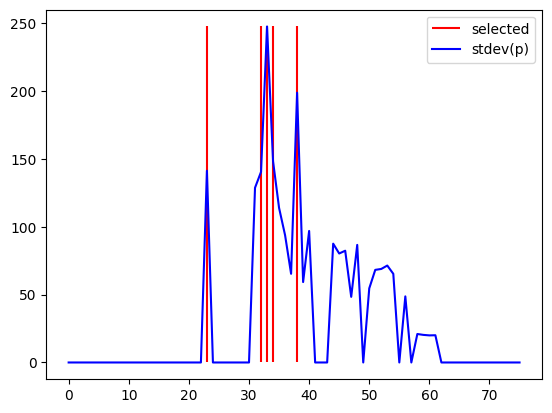

In [15]:
plt.vlines(x=indices, ymin=0., ymax=np.max(stdev), color="red", label="selected")
plt.plot(stdev, color="blue", label="stdev(p)")
plt.legend()

Now generate plots of the dispatch instructions and commitments for the selected generators:

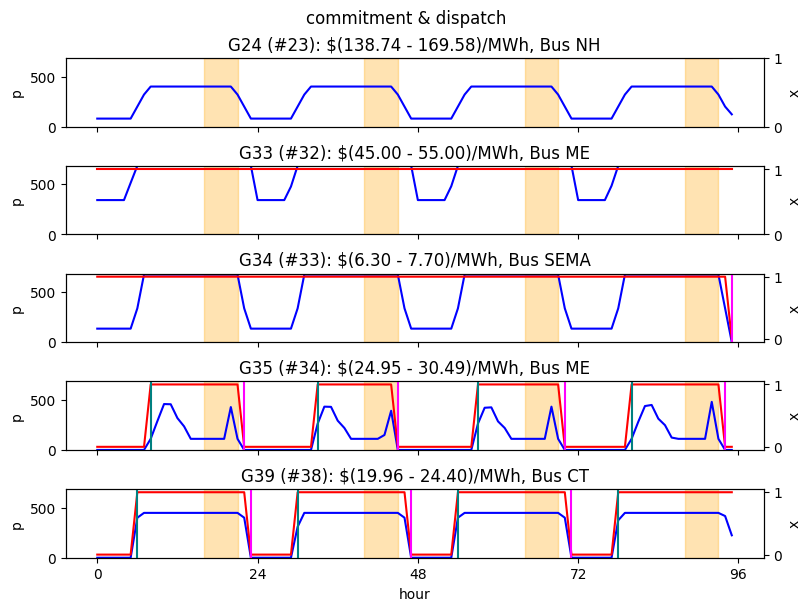

In [16]:
fig, axes = plt.subplots(nrows=ntop, sharex=True, figsize=(8, 6), constrained_layout=True)
epsilon = 1e-6  # tolerance on rounding, even for "binary" variables

handles = []
for i, ax_p in zip(indices, axes):
    ax_x = ax_p.twinx()

    ax_p.plot(p_generator[i, :], color="blue", label="p [MW]")
    ax_x.plot(x_on.value[i, :], color="red", label="x_on [0/1]")
    for x in np.where(epsilon < x_su.value[i,:])[0]:
        ax_x.axvline(x, color="teal", label="x_su [0/1]")
    for x in np.where(epsilon < x_sd.value[i,:])[0]:
        ax_x.axvline(x, color="magenta", label="x_sd [0/1]")

    ax_p.set_title(
        (
            f"{generators.at[i, 'id']} (#{i}): "
            f"$({prices_min[i]:.2f} - {prices_max[i]:.2f})/MWh, "
            f"Bus {generators.at[i, 'bus_id']}"
        )
    )
    ax_p.set_xlabel("hour")
    ax_p.set_xticks(range(0, p_generator.shape[1] + 1, 24))
    ax_p.set_ylim(pmin, pmax)
    ax_p.set_ylabel("p")
    ax_x.set_ylabel("x")
    ax_x.set_yticks([0, 1])

    # Save space between plots
    if ax_p != axes[-1]:
        ax_p.set_xlabel(None)

    # Shade peak hours each day (estimates)
    peak_start = 16  # [hour]
    peak_end = 21  # [hour]
    for offset in range(0, p_generator.shape[1], 24):
        ax_p.axvspan(
            offset + peak_start,
            offset + peak_end,
            color="orange",
            alpha=0.3,
            label=f"peak ({peak_start:02d}H-{peak_end:-02d}H)",
        )

fig.suptitle("commitment & dispatch")
axes[-1].set_xlabel("hour")
plt.show(block=False)

# _Marginal Costs are not Fixed!_

_What would happen if we did account for fixed costs in the OPF problem_ (by introducing using an `x_on`)?

Let's return to simple 1-bus network from the first worksheet and incorate the fixed costs (previously ignored)

In [17]:
from part1_mp_helpers import clear_offer_stack_fp

data = sea2025.data.read("data/fc1bus")

def solve_fp(load: float):
    """Total and cost and increment (with respect to 1MW load increment) for dispatch problem with fixed costs."""
    global data
    result = clear_offer_stack_fp(data, load=load) # "OPF with commitment variables"
    perturbed = clear_offer_stack_fp(data, load=load + 1.0)
    price_delta = perturbed.total_cost - result.total_cost
    return result.total_cost, price_delta


loads = np.linspace(0, data.generators["capacity"].sum() - 1.0, 100)
costs = [solve_fp(load) for load in loads]
total_costs, marginal_costs = zip(*costs)

Skip the plotting commands below and discuss the output with your neighbour:
* How to cost increments relate to marginal costs and to the total cost?
* Can we explain the cost increments in light of the problem data (`generators` and `offers`)?

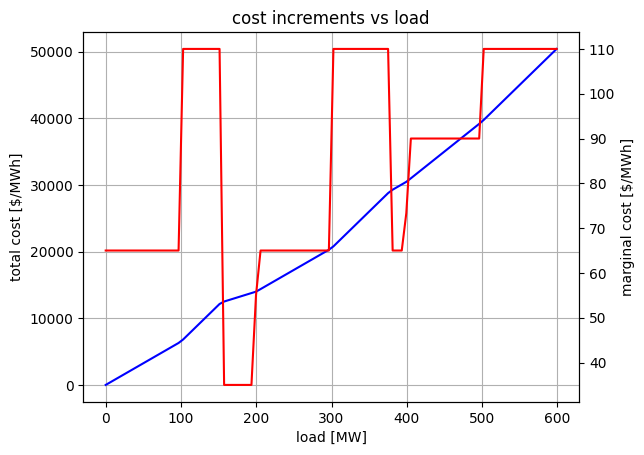

<Figure size 640x480 with 0 Axes>

In [18]:
fig, ax_total = plt.subplots()
ax_marginal = ax_total.twinx()
ax_marginal.plot(loads, marginal_costs, label="marginal cost [$/MWh]", color="red")
ax_marginal.set_ylabel("marginal cost [$/MWh]")
ax_total.plot(loads, total_costs, label="cost [$/MWh]", color="blue")
ax_total.set_xlabel("load [MW]")
ax_total.set_ylabel("total cost [$/MWh]")
ax_total.set_title("cost increments vs load")
ax_total.grid(True)
plt.show(block=False)
plt.savefig("images/non-monotonic-prices.png")